In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import re
import torch
from tqdm import tqdm
import warnings 
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
N_atoms = 1024
T = 2000

In [5]:
folder = '../data/partial_sampling_atoms_8192'
# folder = '../data/partial_sampling_atoms_65536'
kmc_time = np.load(os.path.join(folder, f'kmc_times_T_{T}_seed_0.npy'))
z1_train_partial = np.load(os.path.join(folder, f'z1_train_partial_T_{T}_seed_0.npy'))
z0_train = np.load(os.path.join(folder, f'z0_train_T_{T}_seed_0.npy'))
step = np.load(os.path.join(folder, f'step_T_{T}_seed_0.npy'))

In [8]:
folder = '../data/partial_sampling_atoms_8192'
# folder = '../data/partial_sampling_atoms_65536'
# folder = '../data/partial_sampling_atoms_524288'

time_step_list = []
z1_train_partial_list = []
z0_train_list = []
T_list = []
step_list = []

# for T in [300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]:
for T in [1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]:
# for T in [2000]:
    for seed in range(10):
    # for seed in range(100):

        kmc_time = np.load(os.path.join(folder, f'kmc_times_T_{T}_seed_{seed}.npy'))
        z1_train_partial = np.load(os.path.join(folder, f'z1_train_partial_T_{T}_seed_{seed}.npy'))
        z0_train = np.load(os.path.join(folder, f'z0_train_T_{T}_seed_{seed}.npy'))
        step = np.load(os.path.join(folder, f'step_T_{T}_seed_{seed}.npy'))

        time_step_list.append(kmc_time)
        z1_train_partial_list.append(z1_train_partial)
        z0_train_list.append(z0_train)
        T_list.append(T * np.ones_like(kmc_time))

        # ALERT: since we are using 8192 atoms, we need to multiply the step by 8
        step_list.append(step * 8)
        # step_list.append(step * 64)
        # step_list.append(step * 64 * 8)

T_list = np.stack(T_list, axis=0)
time_step_list = np.stack(time_step_list, axis=0)
z1_train_partial_list = np.stack(z1_train_partial_list, axis=0)
z0_train_list = np.stack(z0_train_list, axis=0)
step_list = np.stack(step_list, axis=0)


T_list.shape, z1_train_partial_list.shape, z0_train_list.shape, step_list.shape

((80, 2000), (80, 2000, 6), (80, 2000, 6), (80, 2000))

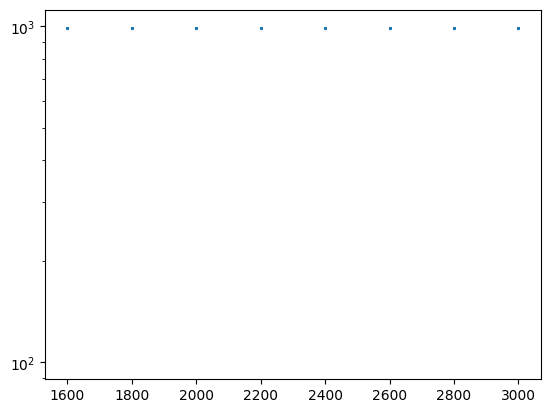

In [10]:
plt.scatter(T_list.flatten(), step_list.flatten(), alpha=0.5, s=0.01)
plt.yscale('log')
plt.show()

In [ ]:
final_time = {}
T_unique = np.unique(T_list[:, 0])
for T in T_unique:
    idx = np.where(T_list[:, 0] == T)[0]
    steps = step_list[idx]
    time_step = time_step_list[idx]
    mean_time = np.mean(time_step / steps)

    total_time = mean_time * 2e6 
    # total_time = mean_time * 2e6 * 8
    # total_time = mean_time * 2e6 * 64
    final_time[T] = total_time

In [12]:
def scale_function(T):
    # Convert T to numpy array if it isn't already
    T = np.asarray(T)
    
    # Handle scalar case
    if T.ndim == 0:
        return 1 / final_time[int(T.item())]
    
    # Handle array case
    result = np.zeros_like(T, dtype=float)
    for i, temp in enumerate(T.flat):
        result.flat[i] = 1 / final_time[int(temp)]
    
    return result

In [13]:
final_time[2000]

np.float64(4.115693435641221e-05)

In [14]:
final_time_scaled = {}
for key, val in final_time.items():
    # final_time_scaled[key] = scale_function(key) * val
    final_time_scaled[key] = scale_function(key) * val

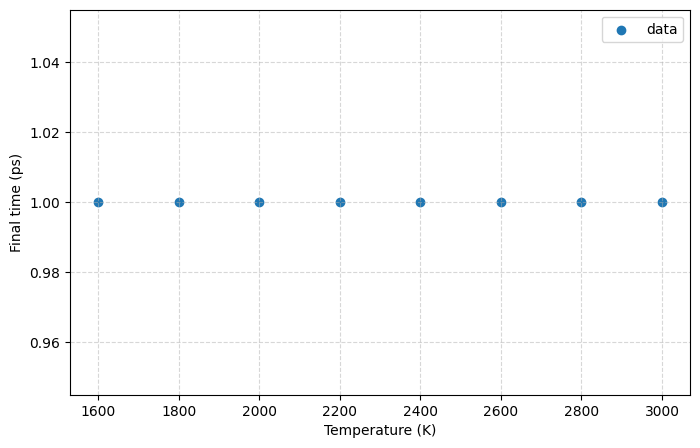

In [15]:
plt.figure(figsize=(8,5))
plt.scatter(final_time_scaled.keys(), final_time_scaled.values(), label="data", color="C0")
plt.xlabel("Temperature (K)")
plt.ylabel("Final time (ps)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [16]:
time_step_list = time_step_list * scale_function(T_list)

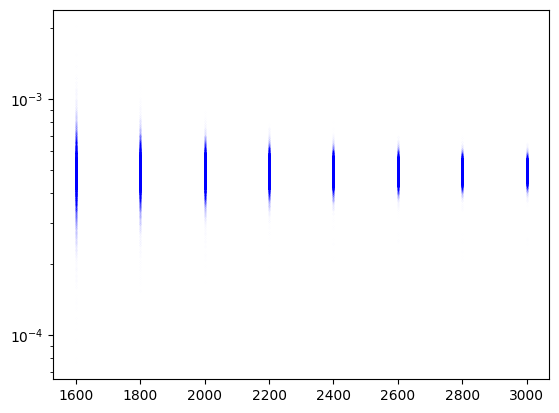

In [18]:
plt.plot(T_list, time_step_list, 'bo', alpha=0.05, markersize=0.05)
plt.yscale('log')
plt.show()

In [19]:
delta_z = z1_train_partial_list - z0_train_list
delta_z.shape

(80, 2000, 6)

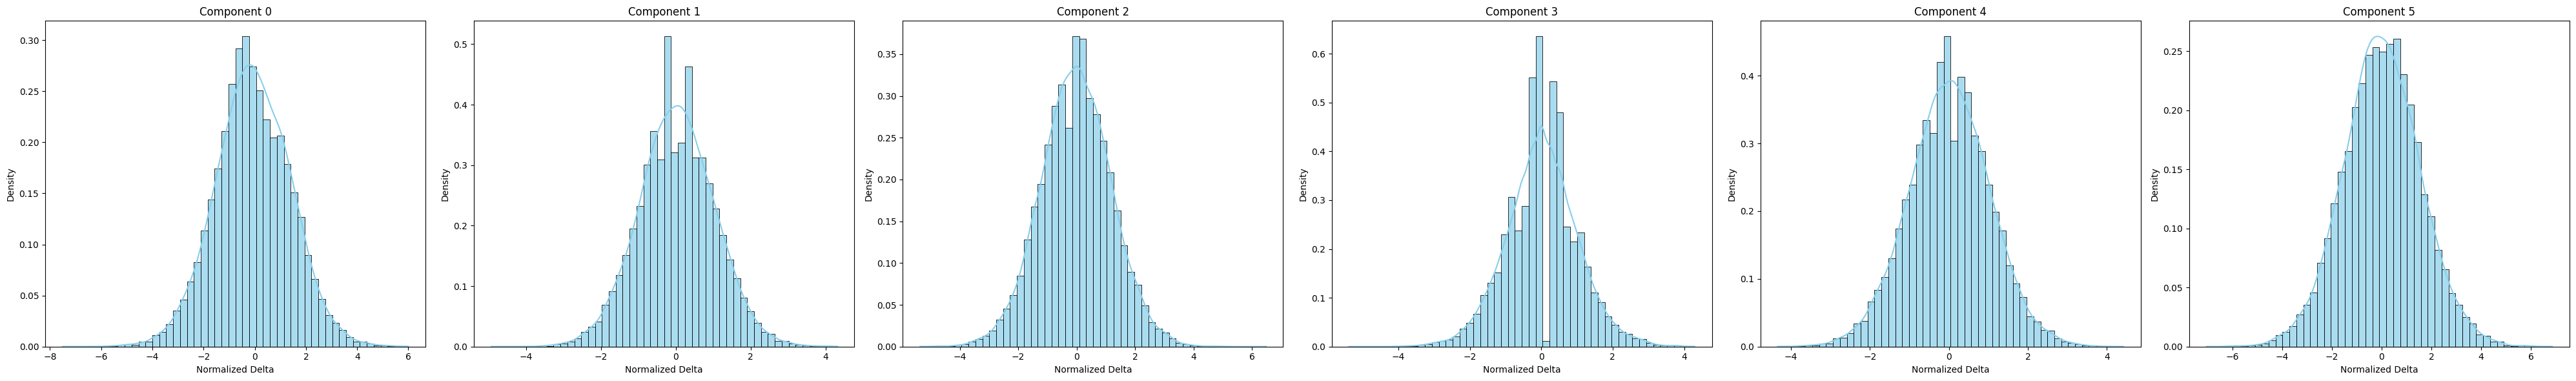

In [20]:
delta_z = z1_train_partial_list - z0_train_list
index = np.where((T_list[:, 0] == 500))[0]
index_2000 = np.where((T_list[:, 0] == 2000))[0]
fig = plt.figure(figsize=(40, 6))
for i in range(6):
    axes = fig.add_subplot(1, 6, i+1)

    sns.histplot((delta_z[index, :, i]).flatten() / np.sqrt(time_step_list[index]).flatten(),
                 ax=axes, kde=True, bins=50, alpha=0.5, color='tab:orange', label='Partial Sampling', stat='density')

    sns.histplot((delta_z[index_2000, :, i]).flatten() / np.sqrt(time_step_list[index_2000]).flatten(),
                 ax=axes, kde=True, bins=50, color='skyblue', alpha=0.7, stat='density')

    axes.set_title(f'Component {i}')
    axes.set_xlabel('Normalized Delta')
    axes.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [21]:
z0_train_list = torch.tensor(z0_train_list, dtype=torch.float32)
z1_train_partial_list = torch.tensor(z1_train_partial_list, dtype=torch.float32)
time_step_list = torch.tensor(time_step_list, dtype=torch.float32)
T_list = torch.tensor(T_list, dtype=torch.int32)

torch.save(z0_train_list, f'{folder}/z0_train.pt')
torch.save(z1_train_partial_list, f'{folder}/z1_train_partial.pt')
torch.save(time_step_list, f'{folder}/time_step.pt')
torch.save(T_list, f'{folder}/T.pt')

In [ ]:
folder 